In [1]:
import warnings
warnings.filterwarnings('ignore')

# always essential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# general tools
from sklearn.decomposition import PCA
from scipy.spatial import distance

# image processing
import cv2
from PIL import Image, ImageOps
from skimage.transform import resize
from skimage.util import pad
from keras.preprocessing.image import ImageDataGenerator
#import imgaug as ia
#from imgaug import augmenters as iaa

# label encoding 
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

# CNN model
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import  Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf

# system/util
import glob
import os
from collections import Counter

%matplotlib inline

Using TensorFlow backend.


cascade_path = './model/cv2/haarcascade_frontalface_alt2.xml'
cascade = cv2.CascadeClassifier(cascade_path)

%load_ext autoreload
%autoreload 1
%aimport inception_resnet_v1

model_path = './model/keras/model/facenet_keras.h5'
weights_path='./model/keras/weight/facenet_keras_weights.h5'
model = inception_resnet_v1.InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=weights_path)

#model = load_model(model_path)

In [2]:
image_path = './input/images-train/*/*.jpg'

## Load Images

In [28]:
images = []
files = []
names = []
for filename in glob.glob(image_path): 
    im=Image.open(filename)
    images.append(np.array(im))
    files.append(filename)
    names.append(filename.split('\\')[1])
    im.close()
    
files = np.array(files)
names = np.array(names)

## Load tests

In [29]:
tests = []
test_files = []
for filename in glob.glob('./input/images-val-pub/*.jpg'): 
    im=Image.open(filename)
    test_files.append(filename)
    tests.append(np.array(im))
    im.close()
test_files = np.array(test_files)

### Statistics

Total files: 5211
Total celeberties: 98


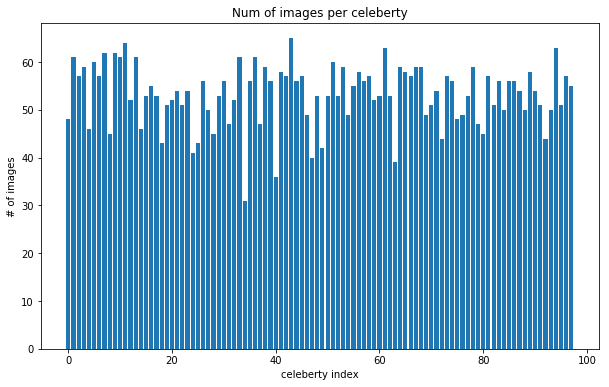

In [5]:
count = Counter(names)
print('Total files:',len(files))
print('Total celeberties:',len(count))

plt.figure(figsize=(10, 6))

plt.bar(range(len(count)), list(count.values())[::-1], align='center')
plt.title("Num of images per celeberty")
plt.xlabel('celeberty index')
plt.ylabel('# of images')

plt.show()

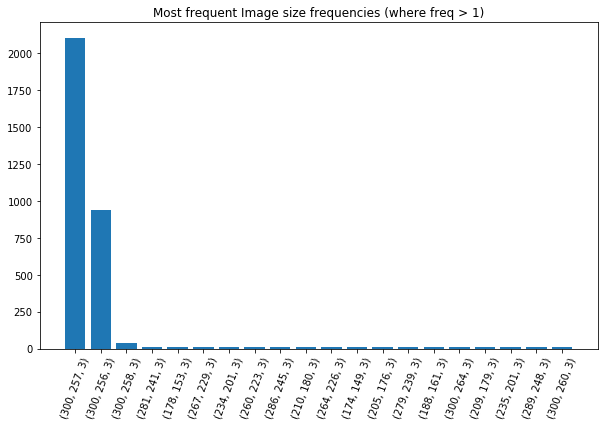

In [6]:
img_sizes = Counter([i.shape for i in images])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Most frequent Image size frequencies (where freq > 1)")

plt.show()

### Look at a sample

adam_levine


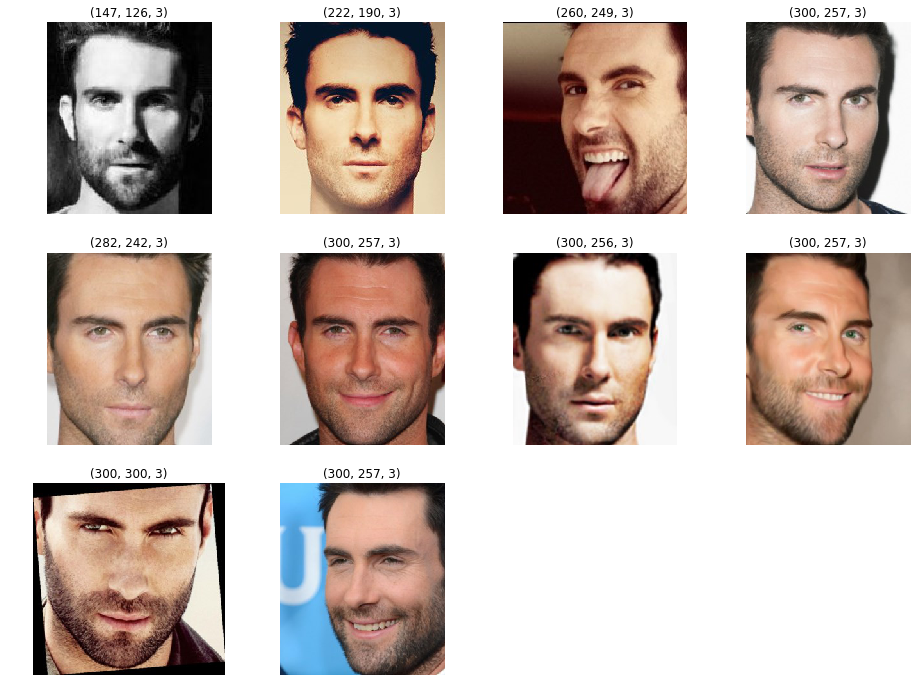

In [7]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[:10]) // rows +1

for i in range(len(images[:10])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].shape, fontsize=12)
    plt.imshow(images[i], cmap='gray')
print(names[9])

## Processing

In [8]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y


In [22]:
def align_images(img, margin,desired_size=160):
    faces = cascade.detectMultiScale(img,
                                     scaleFactor=1.1,
                                     minNeighbors=3)
    (x, y, w, h) = faces[0]
    cropped = img[y-margin//2:y+h+margin//2,
                  x-margin//2:x+w+margin//2, :]
    aligned = resize(cropped, (image_size, image_size), mode='edge')
    aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [23]:
image_size = 160
margin = 10

In [30]:
def pad2sqr(img, desired_size = 160):
    w,h = img.shape[0:2]
    ratio = float(desired_size)/max(w,h)
    new_size = (int(ratio*w), int(ratio*h), 3)
    img = resize(img,new_size)
    w_diff = desired_size-new_size[0]
    w_diff_half = w_diff // 2
    h_diff = desired_size-new_size[1]
    h_diff_half = h_diff //2
    pad0 = (w_diff_half,w_diff-w_diff_half)
    pad1 = (h_diff_half,h_diff-h_diff_half)
    img = pad(img, (pad0,pad1,(0,0)), mode='edge')
    return img

In [31]:
for i in range(len(images)):
    padded = pad2sqr(images[i], image_size)
    images[i] = padded
images = np.stack(images)

print(images.shape)

(5211, 160, 160, 3)


In [32]:
for i in range(len(tests)):
    padded = pad2sqr(tests[i], 160)
    tests[i] = padded
tests = np.stack(tests)
print(tests.shape)

(2628, 160, 160, 3)


### Look at the result

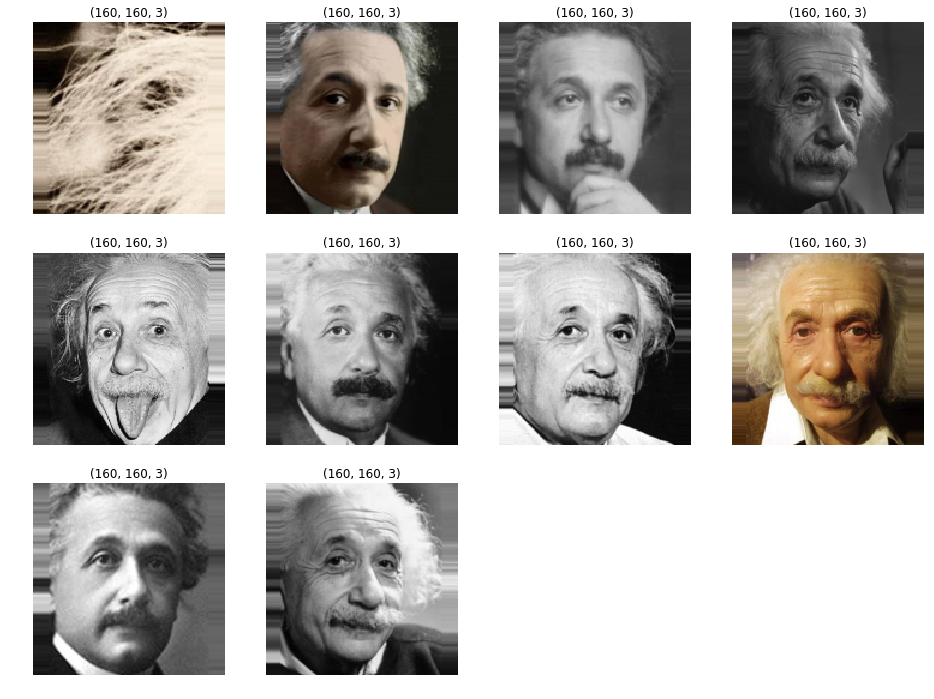

In [54]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[60:70]) // rows +1

for i in range(len(images[60:70])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].shape, fontsize=12)
    plt.imshow(images[i+60], cmap='gray')


### Label encoding

In [34]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
le = preprocessing.LabelEncoder()
le.fit(names)
encoded_names = to_categorical(le.transform(names), num_classes = 98)

### Save numpy array

In [57]:
#np.save('./input/X_train_160.npy', images)
np.save('./input/names.npy', np.array(list(le.classes_)))
np.save('./input/Y_train.npy', encoded_names)
#np.save('./input/X_test_160.npy', tests)
np.save('./input/test_files.npy', test_files)